# WebScrapping DF Imóveis

In [ ]:
# Instalação básica de dependências no Google Colab
!apt-get update -qq > /dev/null
!apt-get install -y wget unzip curl > /dev/null

# 🔧 Instalação do Google Chrome
!wget -q https://dl.google.com/linux/direct/google-chrome-stable_current_amd64.deb
!dpkg -i google-chrome-stable_current_amd64.deb > /dev/null || apt-get -fy install > /dev/null

# Verificando versão instalada
!google-chrome --version

# Instalação do ChromeDriver (compatível automaticamente)
!CHROME_VERSION=$(google-chrome --version | grep -oP '\d+\.\d+\.\d+') && \
  DRIVER_VERSION=$(curl -s "https://googlechromelabs.github.io/chrome-for-testing/known-good-versions-with-downloads.json" | \
  grep -B3 "$CHROME_VERSION" | grep -oP '"version":\s*"\K[^"]+') && \
  wget -q "https://edgedl.me.gvt1.com/edgedl/chrome/chrome-for-testing/$DRIVER_VERSION/linux64/chromedriver-linux64.zip" -O chromedriver.zip && \
  unzip -o chromedriver.zip && mv chromedriver-linux64/chromedriver /usr/bin/ && chmod +x /usr/bin/chromedriver

# Verificação final
!chromedriver --version


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
dpkg: dependency problems prevent configuration of google-chrome-stable:
 google-chrome-stable depends on libvulkan1; however:
  Package libvulkan1 is not installed.

dpkg: error processing package google-chrome-stable (--install):
 dependency problems - leaving unconfigured
Errors were encountered while processing:
 google-chrome-stable
Google Chrome 140.0.7339.207 
/bin/bash: line 1: chromedriver: command not found


In [ ]:
# Instalação do Selenium e Pandas
!pip install -q selenium pandas undetected-chromedriver beautifulsoup4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.4/65.4 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 499.2/499.2 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 2.4 MB/s eta 0:00:00


In [ ]:
import time
import re
import pandas as pd
import undetected_chromedriver as uc
from bs4 import BeautifulSoup
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

# Importar exceções específicas para um tratamento de erros mais claro
from selenium.common.exceptions import TimeoutException, NoSuchElementException

def configurar_driver():
    """Configura e retorna uma instância do Chrome driver."""
    options = uc.ChromeOptions()
    user_agent = ("Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
                  "AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36")
    options.add_argument(f"--user-agent={user_agent}")
    options.add_argument("--no-sandbox")
    options.add_argument("--disable-dev-shm-usage")
    options.add_argument("--disable-blink-features=AutomationControlled")
    options.add_argument("--disable-extensions")
    options.add_argument("--window-size=1920,1080")
    options.add_argument("--headless=new")
    return uc.Chrome(options=options)

def extrair_dados_imovel(card_soup):
    """Extrai informações de um único card de imóvel."""
    texto_completo = card_soup.get_text(" ", strip=True)

    # Extrai o preço usando regex
    preco_match = re.search(r"(R\$\s?[\d\.]+)", texto_completo)
    preco = preco_match.group(1).replace("R$ ", "R$") if preco_match else None

    # Extrai quartos e área
    quartos = next((token for token in texto_completo.split() if "quarto" in token.lower()), None)
    area = next((token for token in texto_completo.split() if "m²" in token), None)

    # Extrai Título e Localização
    titulo = None
    localizacao = None
    linhas = [linha.strip() for linha in texto_completo.splitlines() if linha.strip()]

    # Lógica para encontrar o título (primeira linha relevante que não seja o preço)
    for linha in linhas:
        if "R$" not in linha and len(linha) > 5: # Critério para ser um título
            titulo = linha
            break # Pega o primeiro que encontrar

    # Lógica para encontrar a localização
    for linha in linhas:
        if re.search(r"(Brasília|DF|Quadra|Setor|Asa|Lago|Guará)", linha, re.IGNORECASE):
            localizacao = linha
            break

    return {
        "Título": titulo,
        "Preço": preco,
        "Localização": localizacao,
        "Quartos": quartos,
        "Área": area
    }

# --- Bloco Principal de Execução ---
if __name__ == "__main__":
    URL_BASE = "https://www.dfimoveis.com.br/aluguel/df/brasilia/apartamento"
    MAX_PAGINAS = 100

    driver = configurar_driver()
    dados_imoveis = []
    pagina_atual = 1

    try:
        driver.get(URL_BASE)

        while pagina_atual <= MAX_PAGINAS:
            print(f"Processando página {pagina_atual} de {MAX_PAGINAS}...")

            try:
                # Aguarda a presença de um elemento de preço, indicando que os cards carregaram
                WebDriverWait(driver, 20).until(
                    EC.presence_of_element_located((By.XPATH, "//*[contains(text(),'R$')]"))
                )
                time.sleep(3) # Pausa extra para garantir a renderização completa
            except TimeoutException:
                print("Tempo de espera excedido. Nenhum anúncio encontrado nesta página. Encerrando.")
                break

            soup = BeautifulSoup(driver.page_source, "html.parser")
            cards = soup.find_all("a", class_="imovel-card")

            if not cards:
                print("Nenhum card de imóvel encontrado na página. Encerrando.")
                break

            for card in cards:
                dados_coletados = extrair_dados_imovel(card)
                dados_imoveis.append(dados_coletados)

            # Tenta navegar para a próxima página
            try:
                # Seletor CSS para o botão 'próximo'
                seletor_proxima_pagina = "span.btn.btn-icon-sm.btn-accent.btn-outlined.next"
                botao_proximo = WebDriverWait(driver, 10).until(
                    EC.element_to_be_clickable((By.CSS_SELECTOR, seletor_proxima_pagina))
                )
                # Usa JavaScript para clicar, uma abordagem mais robusta
                driver.execute_script("arguments[0].click();", botao_proximo)
                pagina_atual += 1
            except (TimeoutException, NoSuchElementException):
                print("Não foi possível encontrar o botão 'próxima página'. Fim da navegação.")
                break

    finally:
        # Garante que o driver seja fechado mesmo se ocorrer um erro
        print("\nFechando o navegador...")
        driver.quit()

    # Salva os dados coletados em um arquivo CSV
    if dados_imoveis:
        df = pd.DataFrame(dados_imoveis)
        nome_arquivo = "dfimoveis_imoveis_100_paginas.csv"
        df.to_csv(nome_arquivo, index=False, encoding="utf-8-sig")
        print(f"\nColeta finalizada! {len(df)} imóveis salvos em '{nome_arquivo}'.")
    else:
        print("\nNenhum dado foi coletado.")

Processando página 1 de 100...
Processando página 2 de 100...
Processando página 3 de 100...
Processando página 4 de 100...
Processando página 5 de 100...
Processando página 6 de 100...
Processando página 7 de 100...
Processando página 8 de 100...
Processando página 9 de 100...
Processando página 10 de 100...
Processando página 11 de 100...
Processando página 12 de 100...
Processando página 13 de 100...
Processando página 14 de 100...
Processando página 15 de 100...
Processando página 16 de 100...
Processando página 17 de 100...
Processando página 18 de 100...
Processando página 19 de 100...
Processando página 20 de 100...
Processando página 21 de 100...
Processando página 22 de 100...
Processando página 23 de 100...
Processando página 24 de 100...
Processando página 25 de 100...
Processando página 26 de 100...
Processando página 27 de 100...
Processando página 28 de 100...
Processando página 29 de 100...
Processando página 30 de 100...
Processando página 31 de 100...
Processando págin

In [ ]:
# Importando as bibliotecas necessárias
import pandas as pd
import numpy as np
import re

# Carregar o conjunto de dados a partir do arquivo CSV
try:
    df = pd.read_csv('dfimoveis_imoveis_100_paginas.csv')
    print("Arquivo carregado com sucesso!")
except FileNotFoundError:
    print("Erro: Arquivo 'dfimoveis_imoveis.csv' não encontrado. Verifique o nome e o caminho do arquivo.")
    # Encerra o script se o arquivo não for encontrado
    exit()

# --- Limpeza e Extração de Características ---

# 1. Renomear colunas para facilitar o acesso
df = df.rename(columns={
    'Preço': 'Preco',
    'Localização': 'Descricao',
    'Área': 'Area_Orig',
    'Quartos': 'Quartos_Orig'
})

# 2. Limpar a coluna 'Preco'
# Remove "R$", pontos de milhar, espaços e converte para número
df['Preco'] = df['Preco'].astype(str).str.replace('R\$', '', regex=True).str.replace('.', '', regex=False).str.strip()
# Mantém apenas as linhas que contêm valores numéricos para preço
df = df[df['Preco'].str.isdigit()]
df['Preco'] = pd.to_numeric(df['Preco'])

# 3. Extrair informações da coluna 'Descricao' usando expressões regulares (regex)
df['Area'] = df['Descricao'].str.extract(r'(\d+)\s*m²').astype(float)
df['Quartos'] = df['Descricao'].str.extract(r'(\d+)\s*Quarto').astype(float)

# 4. Extrair o Bairro
# Divide a string pela vírgula, pega a segunda parte (índice 1) e remove espaços
df['Bairro'] = df['Descricao'].str.split(',').str[1].str.strip()

# 5. Remover linhas onde informações essenciais não foram encontradas
df.dropna(subset=['Preco', 'Area', 'Quartos', 'Bairro'], inplace=True)

# 6. Converter 'Quartos' para tipo inteiro
df['Quartos'] = df['Quartos'].astype(int)

# 7. Selecionar colunas de interesse e remover duplicatas
df_clean = df[['Bairro', 'Area', 'Quartos', 'Preco']].copy()
df_clean.drop_duplicates(inplace=True)

print("\n--- Dados após a limpeza inicial ---")
print(df_clean.head())
print(f"\nNúmero de registros após limpeza: {len(df_clean)}")

Arquivo carregado com sucesso!

--- Dados após a limpeza inicial ---
     Bairro   Area  Quartos  Preco
0  PARK SUL   42.0        1   3490
1  SUDOESTE  190.0        3  10900
2  PARK SUL  101.0        3   6750
3   ASA SUL  281.0        4  18000
5  NOROESTE   80.0        2   6700

Número de registros após limpeza: 635


<>:27: SyntaxWarning: invalid escape sequence '\$'
<>:27: SyntaxWarning: invalid escape sequence '\$'
/tmp/ipython-input-423881054.py:27: SyntaxWarning: invalid escape sequence '\$'
  df['Preco'] = df['Preco'].astype(str).str.replace('R\$', '', regex=True).str.replace('.', '', regex=False).str.strip()


In [ ]:
# --- Tratamento de Outliers (usando o método IQR) ---

print(f"\n--- Iniciando remoção de outliers ---")
print(f"Tamanho do DataFrame antes da remoção: {len(df_clean)}")

# 1. Calcular o primeiro (Q1) e o terceiro (Q3) quartil para Preço
Q1_preco = df_clean['Preco'].quantile(0.25)
Q3_preco = df_clean['Preco'].quantile(0.75)
IQR_preco = Q3_preco - Q1_preco
limite_inferior_preco = Q1_preco - 1.5 * IQR_preco
limite_superior_preco = Q3_preco + 1.5 * IQR_preco

# 2. Calcular o primeiro (Q1) e o terceiro (Q3) quartil para Área
Q1_area = df_clean['Area'].quantile(0.25)
Q3_area = df_clean['Area'].quantile(0.75)
IQR_area = Q3_area - Q1_area
limite_inferior_area = Q1_area - 1.5 * IQR_area
limite_superior_area = Q3_area + 1.5 * IQR_area

# 3. Filtrar o DataFrame, mantendo apenas os valores dentro dos limites
df_final = df_clean[
    (df_clean['Preco'] >= limite_inferior_preco) & (df_clean['Preco'] <= limite_superior_preco) &
    (df_clean['Area'] >= limite_inferior_area) & (df_clean['Area'] <= limite_superior_area)
]

print(f"Tamanho do DataFrame após a remoção: {len(df_final)}")
print("\n--- Amostra dos dados finais (sem outliers) ---")
print(df_final.describe())


--- Iniciando remoção de outliers ---
Tamanho do DataFrame antes da remoção: 635
Tamanho do DataFrame após a remoção: 603

--- Amostra dos dados finais (sem outliers) ---
             Area     Quartos         Preco
count  603.000000  603.000000    603.000000
mean    76.976783    1.928690   4970.669983
std     51.949018    1.048598   3147.417967
min      0.000000    1.000000    400.000000
25%     35.000000    1.000000   2400.000000
50%     60.000000    2.000000   4215.000000
75%    105.000000    3.000000   6700.000000
max    235.000000    5.000000  14500.000000



--- Gerando visualizações da Análise Exploratória ---


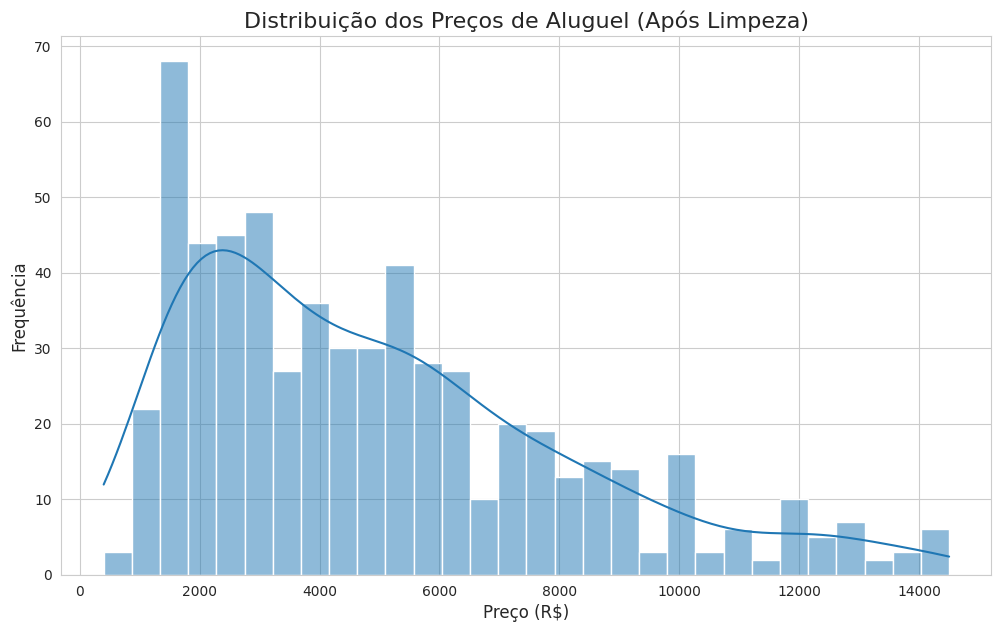

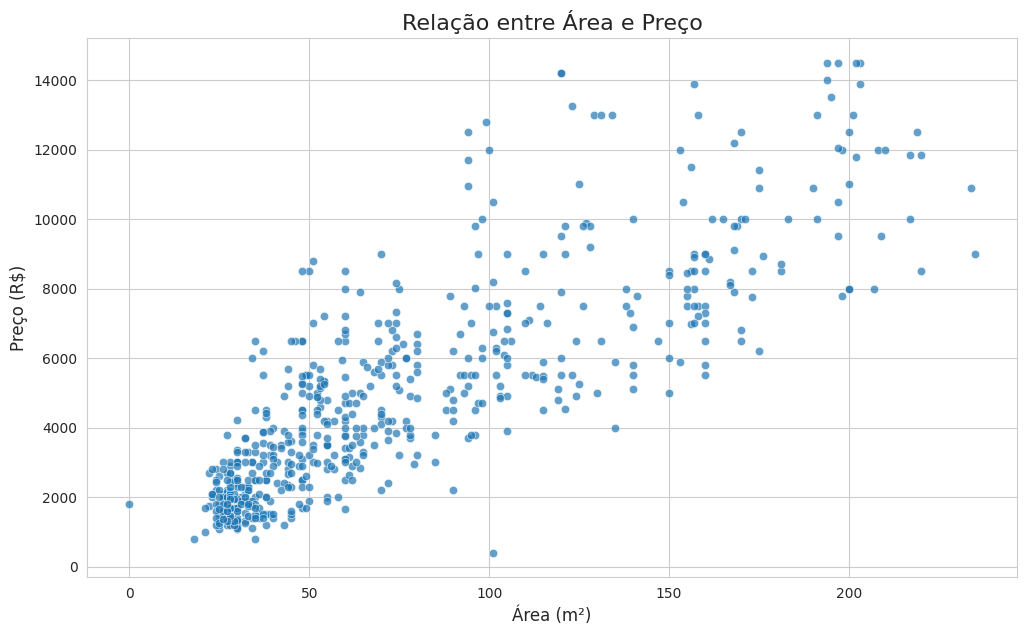

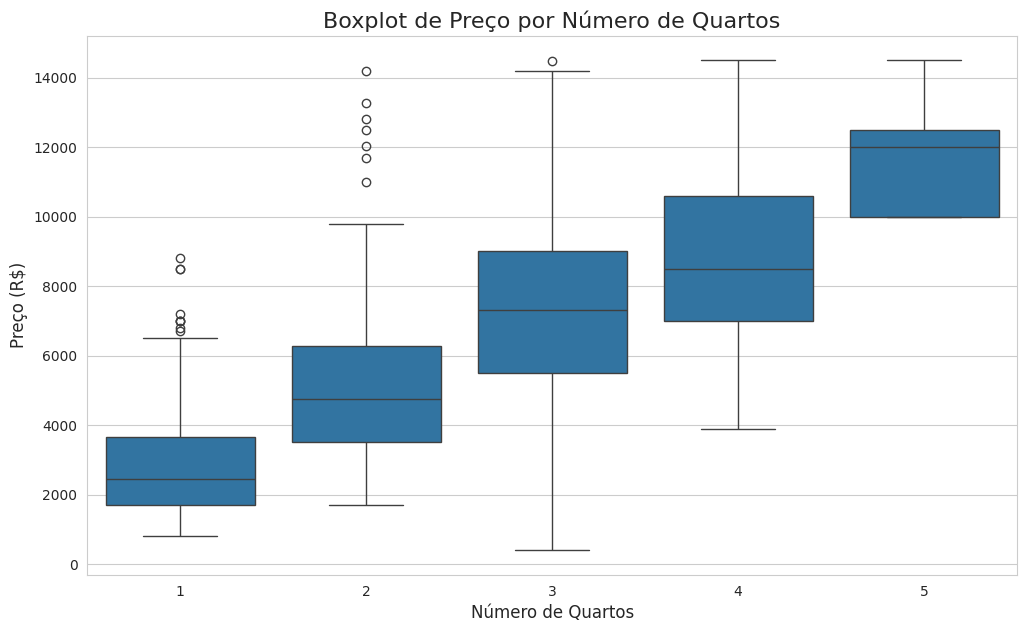

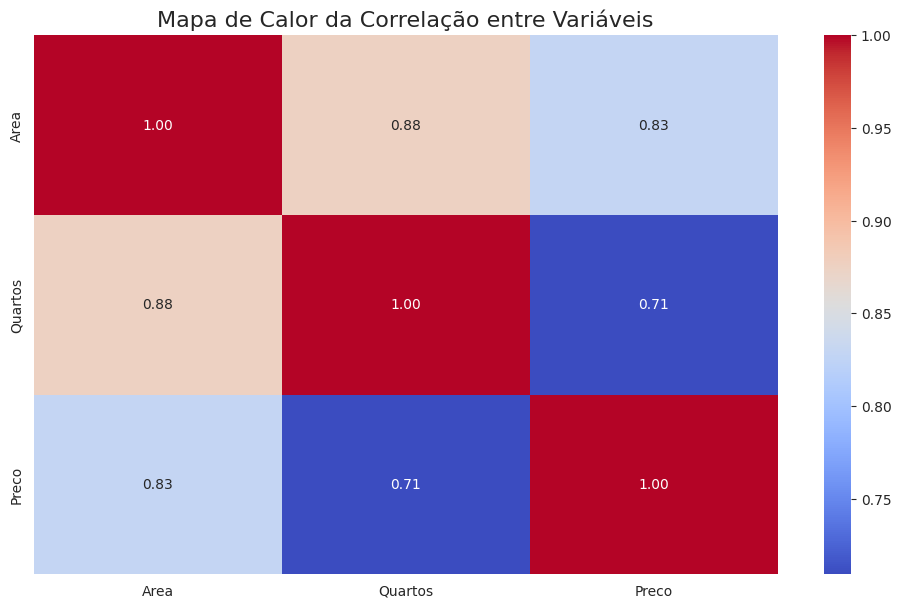


Matriz de Correlação:
             Area   Quartos     Preco
Area     1.000000  0.875671  0.829021
Quartos  0.875671  1.000000  0.709172
Preco    0.829021  0.709172  1.000000


In [ ]:
# Importando bibliotecas de visualização
import matplotlib.pyplot as plt
import seaborn as sns

print("\n--- Gerando visualizações da Análise Exploratória ---")

# Configurações de estilo para os gráficos
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = [12, 7]

# 1. Histograma: Distribuição dos Preços
sns.histplot(df_final['Preco'], kde=True, bins=30)
plt.title('Distribuição dos Preços de Aluguel (Após Limpeza)', fontsize=16)
plt.xlabel('Preço (R$)', fontsize=12)
plt.ylabel('Frequência', fontsize=12)
plt.show()

# 2. Gráfico de Dispersão: Relação entre Área e Preço
sns.scatterplot(x='Area', y='Preco', data=df_final, alpha=0.7)
plt.title('Relação entre Área e Preço', fontsize=16)
plt.xlabel('Área (m²)', fontsize=12)
plt.ylabel('Preço (R$)', fontsize=12)
plt.show()

# 3. Boxplot: Preço por Número de Quartos
sns.boxplot(x='Quartos', y='Preco', data=df_final)
plt.title('Boxplot de Preço por Número de Quartos', fontsize=16)
plt.xlabel('Número de Quartos', fontsize=12)
plt.ylabel('Preço (R$)', fontsize=12)
plt.show()

# 4. Matriz de Correlação e Mapa de Calor
correlation_matrix = df_final[['Area', 'Quartos', 'Preco']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Mapa de Calor da Correlação entre Variáveis', fontsize=16)
plt.show()

print("\nMatriz de Correlação:")
print(correlation_matrix)


--- Construindo o Modelo de Regressão Linear ---

--- Resultados da Avaliação do Modelo ---
Erro Quadrático Médio (MSE): 3051615.52
Raiz do Erro Quadrático Médio (RMSE): 1746.89
Coeficiente de Determinação (R²): 61.93%


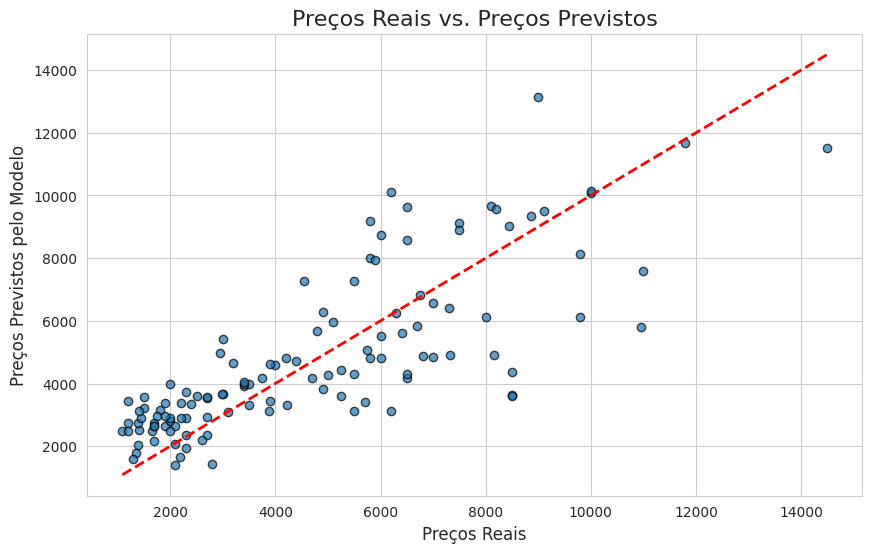

In [ ]:
# Importando as ferramentas de Machine Learning do Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

print("\n--- Construindo o Modelo de Regressão Linear ---")

# 1. Preparação dos dados para o modelo
# Variáveis independentes (X) e variável dependente (y)
X = df_final[['Area', 'Quartos', 'Bairro']]
y = df_final['Preco']

# 2. One-Hot Encoding para a variável categórica 'Bairro'
# Isso transforma os nomes dos bairros em colunas numéricas (0 ou 1)
X = pd.get_dummies(X, columns=['Bairro'], drop_first=True)

# 3. Divisão dos dados em conjuntos de treino e teste (80% treino, 20% teste)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Criação e treinamento do modelo de Regressão Linear
model = LinearRegression()
model.fit(X_train, y_train)

# 5. Realização das previsões no conjunto de teste
y_pred = model.predict(X_test)

# 6. Avaliação da performance do modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n--- Resultados da Avaliação do Modelo ---")
print(f"Erro Quadrático Médio (MSE): {mse:.2f}")
print(f"Raiz do Erro Quadrático Médio (RMSE): {np.sqrt(mse):.2f}")
print(f"Coeficiente de Determinação (R²): {r2:.2%}")

# 7. Visualização dos Resultados do Modelo
plt.figure(figsize=(10, 6))
# Gráfico de dispersão com preços reais vs. previstos
plt.scatter(y_test, y_pred, alpha=0.7, edgecolors='k')
# Linha de referência (previsão perfeita)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
plt.xlabel("Preços Reais", fontsize=12)
plt.ylabel("Preços Previstos pelo Modelo", fontsize=12)
plt.title("Preços Reais vs. Preços Previstos", fontsize=16)
plt.grid(True)
plt.show()